In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import json
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

class SentimentLSTM(nn.Module):
    """LSTM情感分析模型（10类星级分类）"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout, embedding_weights=None, train_embedding=True):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # 嵌入层
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=not train_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout, batch_first=True, bidirectional=False)

        # Dropout层
        self.dropout = nn.Dropout(dropout)

        # 全连接层（输出10个类别的logits）
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 嵌入层
        embedded = self.embedding(x)

        # LSTM层
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # 取最后一个时间步的输出
        out = self.dropout(lstm_out[:, -1, :])

        # 全连接层 -> logits
        logits = self.fc(out)

        return logits  # [batch_size, 10]


def plot_training_history(history, title="训练历史"):
    """绘制训练历史曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 损失曲线
    ax1.plot(history['train_losses'], label='训练损失', linewidth=2)
    ax1.plot(history['val_losses'], label='验证损失', linewidth=2)
    ax1.set_title(f'{title} - 损失曲线')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 准确率曲线
    ax2.plot(history['train_accuracies'], label='训练准确率', linewidth=2)
    ax2.plot(history['val_accuracies'], label='验证准确率', linewidth=2)
    ax2.set_title(f'{title} - 准确率曲线')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

使用设备: cuda


In [5]:
class SentimentAnalyzer:
    """完整的情感分析器类（10类星级）"""

    def __init__(self, device='cpu'):
        self.device = device
        self.vocab_size = 0
        self.model = None
        # 训练指标记录
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_epoch = 0
        self.training_time = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.current_params = None
        self.metrics = {}

    def create_model(self, vocab_size, embedding_dim=100, hidden_dim=128, n_layers=2,
                     dropout=0.3, use_pretrained=False, glove_path=None, train_embedding=True):
        """创建LSTM模型（10类输出）"""
        self.vocab_size = vocab_size
        self.current_params = {
            'vocab_size': vocab_size,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'dropout': dropout,
            'use_pretrained': use_pretrained,
            'train_embedding': train_embedding,
            'num_classes': 10
        }

        if use_pretrained and glove_path:
            embedding_weights = self._load_glove_embeddings(glove_path, embedding_dim, vocab_size)
            if embedding_weights is not None:
                self.model = SentimentLSTM(
                    vocab_size, embedding_dim, hidden_dim, 10, n_layers,
                    dropout, embedding_weights, train_embedding
                )
                print("使用预训练GloVe词向量的模型已创建")
            else:
                print("无法加载预训练词向量，使用随机初始化")
                use_pretrained = False

        if not use_pretrained:
            self.model = SentimentLSTM(
                vocab_size, embedding_dim, hidden_dim, 10, n_layers,
                dropout, None, True
            )
            print("使用随机初始化词向量的模型已创建")

        self.model = self.model.to(self.device)
        return self.model

    def _load_glove_embeddings(self, glove_path, embedding_dim, vocab_size):
        """加载预训练的GloVe词向量（占位：随机）"""
        print("加载GloVe词向量...")
        embedding_weights = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
        try:
            glove_embeddings = {}
            with open(glove_path, 'r', encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    if len(values) < embedding_dim + 1:
                        continue
                    word = values[0]
                    vector = np.asarray(values[1:embedding_dim+1], dtype='float32')
                    glove_embeddings[word] = vector
            print(f"成功加载 {len(glove_embeddings)} 个GloVe词向量")
            print("注意: 由于缺乏索引到词的精确映射，使用随机初始化替代完整GloVe加载")
        except FileNotFoundError:
            print(f"GloVe文件未找到: {glove_path}")
            print("请从 https://nlp.stanford.edu/projects/glove/ 下载GloVe词向量")
            return None
        return torch.tensor(embedding_weights, dtype=torch.float32)

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001,
                    early_stopping_patience=3, save_path='best_model.pth'):
        """训练模型（CrossEntropyLoss，10类）"""
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_epoch = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        print(f"开始训练，学习率: {learning_rate}, 早停耐心值: {early_stopping_patience}")
        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # 训练阶段
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_idx, (sequences, masks, labels, lengths) in enumerate(train_loader):
                sequences = sequences.to(self.device)
                # labels: 1..10 -> shift to 0..9
                labels = (labels - 1).to(self.device).long()

                optimizer.zero_grad()
                logits = self.model(sequences)  # [B, 10]
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predicted = logits.argmax(dim=1)  # [B], 0..9
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # 训练准确率
            train_accuracy = train_correct / max(1, train_total)
            avg_train_loss = train_loss / max(1, len(train_loader))

            # 验证阶段
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for sequences, masks, labels, lengths in val_loader:
                    sequences = sequences.to(self.device)
                    labels = (labels - 1).to(self.device).long()

                    logits = self.model(sequences)
                    loss = criterion(logits, labels)

                    val_loss += loss.item()
                    predicted = logits.argmax(dim=1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_accuracy = val_correct / max(1, val_total)
            avg_val_loss = val_loss / max(1, len(val_loader))

            # 记录指标
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

            # 早停法
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_epoch = epoch + 1
                self.patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f"保存最佳模型，验证损失: {avg_val_loss:.4f}")
            else:
                self.patience_counter += 1

            epoch_time = time.time() - epoch_start_time

            # 打印进度
            print(f'Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s')
            print(f'  训练损失: {avg_train_loss:.4f}, 训练准确率: {train_accuracy:.4f}')
            print(f'  验证损失: {avg_val_loss:.4f}, 验证准确率: {val_accuracy:.4f}')
            print(f'  最佳epoch: {self.best_epoch}, 早停计数: {self.patience_counter}/{early_stopping_patience}')

            # 检查早停
            if self.patience_counter >= early_stopping_patience:
                print(f"早停触发于第 {epoch+1} 个epoch")
                break

        # 记录总训练时间
        self.training_time = time.time() - start_time

        # 加载最佳模型
        self.model.load_state_dict(torch.load(save_path, weights_only=True))

        print(f"训练完成，总时间: {self.training_time:.2f}秒")
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies
        }

    def evaluate_model(self, test_loader):
        """评估模型性能（10类）"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        all_probabilities = []

        with torch.no_grad():
            for sequences, masks, labels, lengths in test_loader:
                sequences = sequences.to(self.device)
                labels = (labels - 1).to(self.device).long()  # 0..9

                logits = self.model(sequences)  # [B,10]
                probs = torch.softmax(logits, dim=1)  # softmax概率
                predictions = logits.argmax(dim=1).cpu().numpy()  # 0..9

                all_predictions.extend(predictions)
                all_targets.extend(labels.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())

        # 计算评估指标（宏平均）
        accuracy = accuracy_score(all_targets, all_predictions)
        precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

        # 保存指标
        self.metrics = {
            'accuracy': accuracy,
            'precision': precision,   # 宏平均
            'recall': recall,         # 宏平均
            'f1': f1,                 # 宏平均F1
            'predictions': all_predictions,
            'targets': all_targets,
            'probabilities': all_probabilities
        }

        # 打印结果（仅报告测试集中出现的类别）
        import numpy as np
        present = np.unique(all_targets)           # 0..9
        target_names = [f'{c+1}星' for c in present]  # 显示为 1..10星
        print("\n" + "="*60)
        print("模型评估结果（10类星级）")
        print("="*60)
        print(f"准确率 (Accuracy): {accuracy:.4f}")
        print(f"宏平均精确率 (Precision-macro): {precision:.4f}")
        print(f"宏平均召回率 (Recall-macro): {recall:.4f}")
        print(f"宏平均F1分数: {f1:.4f}")
        print("\n详细分类报告(仅测试集出现的星级):")
        print(classification_report(all_targets, all_predictions,
                                    labels=present, target_names=target_names, digits=4))

        return self.metrics

    def predict_sentiment(self, text_sequences):
        """预测新文本的星级（保持接口名以兼容原代码）"""
        self.model.eval()
        with torch.no_grad():
            sequences = text_sequences.to(self.device)
            logits = self.model(sequences)
            probs = torch.softmax(logits, dim=1)
            preds0 = torch.argmax(probs, dim=1)  # 0..9
        # 返回 1..10 星级 和 概率分布
        return (preds0 + 1).cpu().numpy(), probs.cpu().numpy()

    def generate_report(self, report_dir='reports', filename='analysis_report.html'):
        """生成完整的分析报告（字段保持一致）"""
        import matplotlib.pyplot as plt
        os.makedirs(report_dir, exist_ok=True)

        report_data = {
            'best_val_loss': self.best_val_loss,
            'best_epoch': self.best_epoch,
            'training_time': self.training_time,
            'parameters': self.current_params,
            'metrics': self.metrics
        }

        html_content = f"""
        <html>
        <head>
            <title>情感分析模型实验报告</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }}
                h1, h2, h3 {{ color: #2c3e50; }}
                .container {{ max-width: 1200px; margin: 0 auto; }}
                .metric-card {{ background: #f8f9fa; padding: 20px; margin: 10px; border-radius: 5px; }}
                .grid {{ display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; }}
                table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #3498db; color: white; }}
                tr:nth-child(even) {{ background-color: #f2f2f2; }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>🧠 情感分析模型实验报告（10类星级）</h1>

                <h2>📊 实验概览</h2>
                <div class="grid">
                    <div class="metric-card">
                        <h3>最佳验证损失</h3>
                        <p>{report_data['best_val_loss']:.4f}</p>
                    </div>
                    <div class="metric-card">
                        <h3>最佳Epoch</h3>
                        <p>{report_data['best_epoch']}</p>
                    </div>
                    <div class="metric-card">
                        <h3>训练时间</h3>
                        <p>{report_data['training_time']:.2f}秒</p>
                    </div>
                    <div class="metric-card">
                        <h3>最终准确率</h3>
                        <p>{report_data['metrics'].get('accuracy', 0):.4f}</p>
                    </div>
                </div>

                <h2>⚙️ 模型参数</h2>
                <pre>{json.dumps(report_data['parameters'], indent=2, ensure_ascii=False)}</pre>

                <h2>📈 性能指标（宏平均）</h2>
                <table>
                    <tr><th>指标</th><th>数值</th></tr>
                    <tr><td>准确率 (Accuracy)</td><td>{report_data['metrics'].get('accuracy', 0):.4f}</td></tr>
                    <tr><td>精确率 (Precision)</td><td>{report_data['metrics'].get('precision', 0):.4f}</td></tr>
                    <tr><td>召回率 (Recall)</td><td>{report_data['metrics'].get('recall', 0):.4f}</td></tr>
                    <tr><td>F1分数</td><td>{report_data['metrics'].get('f1', 0):.4f}</td></tr>
                </table>

                <h2>📉 训练曲线</h2>
                <img src="training_curves.png" width="100%">
            </div>
        </body>
        </html>
        """

        report_path = os.path.join(report_dir, filename)
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(html_content)

        self._plot_training_curves(report_dir)

        print(f"📄 分析报告已生成: {report_path}")
        return report_path

    def _plot_training_curves(self, save_dir):
        """绘制训练曲线"""
        plt.figure(figsize=(15, 5))

        # 损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='训练损失', linewidth=2)
        plt.plot(self.val_losses, label='验证损失', linewidth=2)
        plt.title('训练和验证损失曲线')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 准确率曲线
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='训练准确率', linewidth=2)
        plt.plot(self.val_accuracies, label='验证准确率', linewidth=2)
        plt.title('训练和验证准确率曲线')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
        plt.close()

In [6]:
class ExperimentManager:
    """实验管理器 - 用于超参数调优和对比实验（10类）"""

    def __init__(self, device='cpu'):
        self.device = device
        self.experiment_results = []
        self.best_experiment = None

    def run_hyperparameter_search(self, train_loader, val_loader, test_loader, vocab_size,
                                  param_grid=None, max_experiments=20):
        """运行超参数搜索"""
        if param_grid is None:
            param_grid = {
                'learning_rate': [0.0001, 0.0005, 0.001],
                'batch_size': [32, 64],
                'dropout_rate': [0.2, 0.3, 0.5],
                'hidden_dim': [64, 128],
                'n_layers': [1, 2],
                'use_pretrained': [True, False]
            }

        print("开始超参数搜索实验...")
        experiment_count = 0

        param_combinations = self._generate_param_combinations(param_grid, max_experiments)

        for i, params in enumerate(param_combinations):
            if experiment_count >= max_experiments:
                break

            try:
                print(f"\n🔬 实验 {i+1}/{len(param_combinations)}")
                print(f"参数: {params}")

                batch_size = params['batch_size']
                current_train_loader = DataLoader(
                    train_loader.dataset, batch_size=batch_size, shuffle=True
                )
                current_val_loader = DataLoader(
                    val_loader.dataset, batch_size=batch_size, shuffle=False
                )
                current_test_loader = DataLoader(
                    test_loader.dataset, batch_size=batch_size, shuffle=False
                )

                analyzer = SentimentAnalyzer(device=self.device)
                analyzer.create_model(
                    vocab_size=vocab_size,
                    embedding_dim=100,
                    hidden_dim=params['hidden_dim'],
                    n_layers=params['n_layers'],
                    dropout=params['dropout_rate'],
                    use_pretrained=params['use_pretrained']
                )

                history = analyzer.train_model(
                    current_train_loader, current_val_loader,
                    learning_rate=params['learning_rate'],
                    num_epochs=15,
                    early_stopping_patience=3
                )

                metrics = analyzer.evaluate_model(current_test_loader)

                experiment_result = {
                    'experiment_id': i + 1,
                    'parameters': params,
                    'metrics': metrics,
                    'history': history,
                    'training_time': analyzer.training_time,
                    'analyzer': analyzer
                }

                self.experiment_results.append(experiment_result)

                # 使用 'f1' 作为比较指标（宏平均F1）
                if self.best_experiment is None or metrics['f1'] > self.best_experiment['metrics']['f1']:
                    self.best_experiment = experiment_result
                    print(f"🎯 新的最佳实验! F1分数: {metrics['f1']:.4f}")

                experiment_count += 1

            except Exception as e:
                print(f"❌ 实验 {i+1} 失败: {e}")
                continue

        print(f"\n✅ 超参数搜索完成! 共完成 {len(self.experiment_results)} 个实验")
        return self.experiment_results

    def _generate_param_combinations(self, param_grid, max_experiments):
        """生成参数组合"""
        keys = param_grid.keys()
        values = param_grid.values()

        combinations = []
        for combination in product(*values):
            param_dict = dict(zip(keys, combination))
            combinations.append(param_dict)

        if len(combinations) > max_experiments:
            indices = np.random.choice(len(combinations), max_experiments, replace=False)
            combinations = [combinations[i] for i in indices]

        return combinations

    def generate_comparison_report(self):
        """生成实验对比报告"""
        if not self.experiment_results:
            print("没有实验结果可比较")
            return

        comparison_data = []
        for result in self.experiment_results:
            row = result['parameters'].copy()
            row.update(result['metrics'])
            row['training_time'] = result['training_time']
            row['experiment_id'] = result['experiment_id']
            comparison_data.append(row)

        df = pd.DataFrame(comparison_data)

        self._plot_experiment_comparison(df)

        df.to_csv('experiment_comparison.csv', index=False, encoding='utf-8')

        print(f"\n📊 实验对比报告已生成")
        print(f"最佳实验ID: {self.best_experiment['experiment_id']}")
        print(f"最佳F1分数: {self.best_experiment['metrics']['f1']:.4f}")

        return df

    def _plot_experiment_comparison(self, df):
        """绘制实验对比图"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        axes[0,0].bar(df['experiment_id'], df['f1'], alpha=0.7)
        axes[0,0].set_xlabel('实验ID')
        axes[0,0].set_ylabel('F1分数(宏)')
        axes[0,0].set_title('各实验F1分数对比')
        axes[0,0].grid(True, alpha=0.3)

        axes[0,1].bar(df['experiment_id'], df['accuracy'], alpha=0.7, color='orange')
        axes[0,1].set_xlabel('实验ID')
        axes[0,1].set_ylabel('准确率')
        axes[0,1].set_title('各实验准确率对比')
        axes[0,1].grid(True, alpha=0.3)

        axes[1,0].bar(df['experiment_id'], df['training_time'], alpha=0.7, color='green')
        axes[1,0].set_xlabel('实验ID')
        axes[1,0].set_ylabel('训练时间(秒)')
        axes[1,0].set_title('训练时间对比')
        axes[1,0].grid(True, alpha=0.3)

        if 'use_pretrained' in df.columns:
            pretrained_mean = df[df['use_pretrained'] == True]['f1'].mean()
            random_mean = df[df['use_pretrained'] == False]['f1'].mean()
            axes[1,1].bar(['预训练', '随机'], [pretrained_mean, random_mean], alpha=0.7, color='red')
            axes[1,1].set_ylabel('平均F1分数(宏)')
            axes[1,1].set_title('嵌入类型性能对比')
            axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

In [7]:
def plot_training_history(history, model_name):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_losses'], label='训练损失')
    ax1.plot(history['val_losses'], label='验证损失')
    ax1.set_title(f'{model_name} - 损失曲线')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_accuracies'], label='训练准确率')
    ax2.plot(history['val_accuracies'], label='验证准确率')
    ax2.set_title(f'{model_name} - 准确率曲线')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def simple_train_and_evaluate(analyzer, train_loader, val_loader, test_loader, vocab_size, use_pretrained=False):
    """简化的训练和评估流程（10类）"""
    print("\n" + "="*80)
    print(f"训练{'预训练嵌入' if use_pretrained else '随机嵌入'}模型")
    print("="*80)
    
    analyzer.create_model(
        vocab_size=vocab_size,
        hidden_dim=128,
        dropout=0.3,
        use_pretrained=use_pretrained
    )
    
    history = analyzer.train_model(
        train_loader, val_loader,
        learning_rate=0.001,
        num_epochs=5  # 减少epoch数以加快实验
    )
    
    results = analyzer.evaluate_model(test_loader)
    plot_training_history(history, f"{'预训练嵌入' if use_pretrained else '随机嵌入'}模型")
    
    return results

🤖 情感分析系统 - 完整演示 (10类星级)
📂 加载数据...
✅ 使用数据文件: processed_data_multiclass\all_data.pt
词汇表大小: 30000
训练集: 32000个样本
验证集: 8000个样本
测试集: 10000个样本

1. 🚀 快速训练单个模型...
使用随机初始化词向量的模型已创建
开始训练，学习率: 0.001, 早停耐心值: 3
保存最佳模型，验证损失: 2.0268
Epoch [1/10], Time: 10.89s
  训练损失: 2.0369, 训练准确率: 0.2016
  验证损失: 2.0268, 验证准确率: 0.2061
  最佳epoch: 1, 早停计数: 0/3
保存最佳模型，验证损失: 2.0268
Epoch [2/10], Time: 10.76s
  训练损失: 2.0270, 训练准确率: 0.1997
  验证损失: 2.0268, 验证准确率: 0.2051
  最佳epoch: 2, 早停计数: 0/3
Epoch [3/10], Time: 10.74s
  训练损失: 2.0172, 训练准确率: 0.2060
  验证损失: 2.0313, 验证准确率: 0.1909
  最佳epoch: 2, 早停计数: 1/3
Epoch [4/10], Time: 10.71s
  训练损失: 1.9925, 训练准确率: 0.2198
  验证损失: 2.0588, 验证准确率: 0.2032
  最佳epoch: 2, 早停计数: 2/3
Epoch [5/10], Time: 10.70s
  训练损失: 1.9509, 训练准确率: 0.2363
  验证损失: 2.0838, 验证准确率: 0.2018
  最佳epoch: 2, 早停计数: 3/3
早停触发于第 5 个epoch
训练完成，总时间: 53.79秒

模型评估结果（10类星级）
准确率 (Accuracy): 0.2008
宏平均精确率 (Precision-macro): 0.1018
宏平均召回率 (Recall-macro): 0.1260
宏平均F1分数: 0.0569

详细分类报告(仅测试集出现的星级):
              precision    recall  f1-

 y


开始超参数搜索...
开始超参数搜索实验...

🔬 实验 1/8
参数: {'learning_rate': 0.0005, 'batch_size': 32, 'dropout_rate': 0.3, 'hidden_dim': 64, 'n_layers': 1, 'use_pretrained': False}
使用随机初始化词向量的模型已创建
开始训练，学习率: 0.0005, 早停耐心值: 3
保存最佳模型，验证损失: 2.0284
Epoch [1/15], Time: 3.02s
  训练损失: 2.0528, 训练准确率: 0.1995
  验证损失: 2.0284, 验证准确率: 0.1940
  最佳epoch: 1, 早停计数: 0/3
保存最佳模型，验证损失: 2.0276
Epoch [2/15], Time: 2.89s
  训练损失: 2.0296, 训练准确率: 0.1997
  验证损失: 2.0276, 验证准确率: 0.1935
  最佳epoch: 2, 早停计数: 0/3
保存最佳模型，验证损失: 2.0254
Epoch [3/15], Time: 2.85s
  训练损失: 2.0240, 训练准确率: 0.2063
  验证损失: 2.0254, 验证准确率: 0.1936
  最佳epoch: 3, 早停计数: 0/3
Epoch [4/15], Time: 2.85s
  训练损失: 2.0183, 训练准确率: 0.2087
  验证损失: 2.0261, 验证准确率: 0.2061
  最佳epoch: 3, 早停计数: 1/3
Epoch [5/15], Time: 2.85s
  训练损失: 2.0087, 训练准确率: 0.2118
  验证损失: 2.0255, 验证准确率: 0.2040
  最佳epoch: 3, 早停计数: 2/3
保存最佳模型，验证损失: 2.0136
Epoch [6/15], Time: 2.84s
  训练损失: 1.9874, 训练准确率: 0.2229
  验证损失: 2.0136, 验证准确率: 0.1945
  最佳epoch: 6, 早停计数: 0/3
保存最佳模型，验证损失: 1.9828
Epoch [7/15], Time: 2.84s
  训练损失: 1

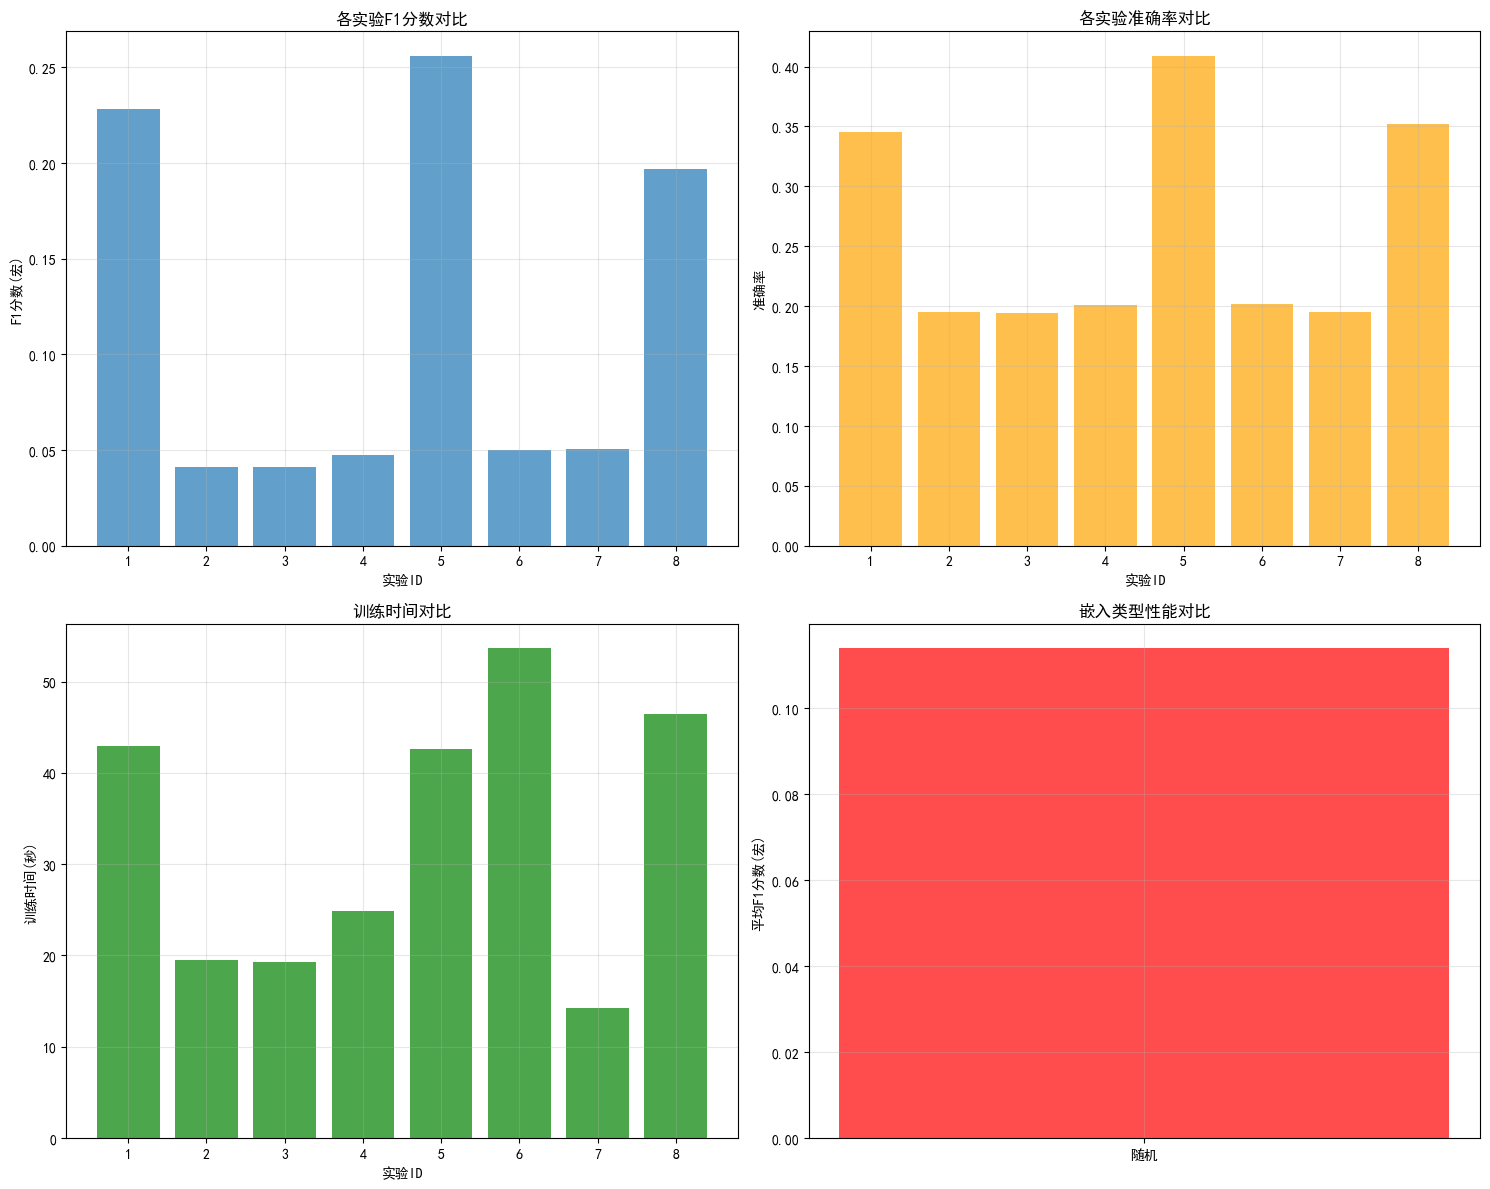


📊 实验对比报告已生成
最佳实验ID: 5
最佳F1分数: 0.2559

✅ 程序执行完成!


In [9]:
from pathlib import Path
import glob

def _resolve_processed_pt_path():
    """Find the processed .pt file saved by the preprocessing pipeline."""
    # Preferred default
    preferred = Path("processed_data_multiclass") / "all_data.pt"
    if preferred.exists():
        print(f"✅ 使用数据文件: {preferred}")
        return preferred

    # Fallback: look for any .pt file in processed_data_multiclass/
    proc_dir = Path("processed_data_multiclass")
    if proc_dir.exists():
        candidates = sorted(proc_dir.glob("*.pt"))
        if candidates:
            print(f"⚠️ 未找到 all_data.pt，改用: {candidates[0]}")
            return candidates[0]
        else:
            raise FileNotFoundError("processed_data_multiclass 目录存在，但未找到任何 .pt 文件")

    # Last resort: try root-level all_data.pt
    root_all = Path("all_data.pt")
    if root_all.exists():
        print(f"⚠️ 使用根目录数据文件: {root_all}")
        return root_all

    raise FileNotFoundError("未找到处理后的数据文件。请确认 processed_data_multiclass/all_data.pt 是否存在。")

def main():
    """完整的演示流程（10类星级）"""
    print("="*80)
    print("🤖 情感分析系统 - 完整演示 (10类星级)")
    print("="*80)

    try:
        # 加载数据（指向 processed_data_multiclass 下的 .pt 文件）
        print("📂 加载数据...")
        data_path = _resolve_processed_pt_path()
        data = torch.load(str(data_path))

        # 创建数据集
        train_dataset = TensorDataset(
            data['train_sequences'], data['train_masks'],
            data['train_labels'], data['train_lengths']
        )
        val_dataset = TensorDataset(
            data['val_sequences'], data['val_masks'],
            data['val_labels'], data['val_lengths']
        )
        test_dataset = TensorDataset(
            data['test_sequences'], data['test_masks'],
            data['test_labels'], data['test_lengths']
        )

        vocab_size = max(
            data['train_sequences'].max().item(),
            data['val_sequences'].max().item(),
            data['test_sequences'].max().item()
        ) + 1

        print(f"词汇表大小: {vocab_size}")
        print(f"训练集: {len(train_dataset)}个样本")
        print(f"验证集: {len(val_dataset)}个样本")
        print(f"测试集: {len(test_dataset)}个样本")

        # 数据加载器
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # 选项1: 快速单个模型训练
        print("\n1. 🚀 快速训练单个模型...")
        analyzer = SentimentAnalyzer(device=device)
        analyzer.create_model(vocab_size=vocab_size, use_pretrained=False)

        history = analyzer.train_model(
            train_loader, val_loader,
            learning_rate=0.001, num_epochs=10
        )

        metrics = analyzer.evaluate_model(test_loader)
        analyzer.generate_report()

        # 选项2: 超参数搜索（可选）
        print("\n2. 🔍 是否进行超参数搜索? (y/n)")
        user_input = input().strip().lower()

        if user_input == 'y':
            print("开始超参数搜索...")
            experiment_manager = ExperimentManager(device=device)

            quick_param_grid = {
                'learning_rate': [0.0005, 0.001],
                'batch_size': [32],
                'dropout_rate': [0.3, 0.5],
                'hidden_dim': [64, 128],
                'n_layers': [1, 2],
                'use_pretrained': [False]
            }

            results = experiment_manager.run_hyperparameter_search(
                train_loader, val_loader, test_loader, vocab_size,
                param_grid=quick_param_grid, max_experiments=8
            )

            experiment_manager.generate_comparison_report()

        print("\n✅ 程序执行完成!")

    except Exception as e:
        print(f"❌ 错误: {e}")
        print("请检查数据文件路径和格式")

if __name__ == "__main__":
    main()